In [1]:
# STEP 1: INSTALL REQUIRED LIBRARIES
# ----------------------------------
#!pip uninstall -y transformers

!pip install transformers==4.57.1 --quiet
!pip install datasets torch torchvision torchaudio --quiet
!pip install accelerate evaluate --quiet
!pip install sentencepiece gradio PyPDF2 scikit-learn --quiet

# Import important libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Hugging Face tools
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# For visualization
import matplotlib.pyplot as plt

# For file upload
from google.colab import files
import PyPDF2
import gradio as gr

import transformers
print("✅ All libraries installed and imported successfully!")
print("Transformers version:", transformers.__version__)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.2 MB/s eta 0:00:00


✅ All libraries installed and imported successfully!
Transformers version: 4.57.1


In [2]:

# STEP 2: UPLOAD AND LOAD THE DATASET
# -----------------------------------
from google.colab import files
import pandas as pd

# Upload your dataset (you’ll get a file upload button)
uploaded = files.upload()

# Read the uploaded CSV file
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, encoding='utf-8')

# Display first few rows to check data
print("✅ Dataset loaded successfully!\n")
print("Number of records:", len(df))
df.head()


Saving UpdatedResumeDataSet.csv to UpdatedResumeDataSet.csv
✅ Dataset loaded successfully!

Number of records: 962


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [3]:
# STEP 3: DATA CLEANING AND PREPARATION
# -------------------------------------

import re
from sklearn.preprocessing import LabelEncoder

# Check dataset columns
print("Columns in dataset:", df.columns.tolist())

# Rename columns if needed (make sure they match correctly)
# Usually, dataset has 'Category' and 'Resume' columns
df.rename(columns={'Category': 'category', 'Resume': 'resume'}, inplace=True)

# Drop rows with missing data
df.dropna(subset=['category', 'resume'], inplace=True)

# Clean the text: remove URLs, numbers, special characters, and extra spaces
def clean_text(text):
    text = re.sub(r'http\S+', '', text)                 # remove URLs
    text = re.sub(r'\d+', '', text)                     # remove numbers
    text = re.sub(r'[^\w\s]', '', text)                 # remove punctuation
    text = text.lower().strip()                         # lowercase and trim
    return text

df['cleaned_resume'] = df['resume'].apply(clean_text)

# Encode category labels to numeric values
label_encoder = LabelEncoder()
df['encoded_category'] = label_encoder.fit_transform(df['category'])

# Show few samples
print("✅ Data cleaned and labels encoded successfully!\n")
df[['category', 'encoded_category', 'cleaned_resume']].head(10)


Columns in dataset: ['Category', 'Resume']
✅ Data cleaned and labels encoded successfully!



,category,encoded_category,cleaned_resume
0,Data Science,6,skills programming languages python pandas nu...
1,Data Science,6,education details \r\nmay to may be uitrgp...
2,Data Science,6,areas of interest deep learning control system...
3,Data Science,6,skills â r â python â sap hana â tableau â sap...
4,Data Science,6,education details \r\n mca ymcaust faridaba...
5,Data Science,6,skills c basics iot python matlab data science...
6,Data Science,6,skills â python â tableau â data visualization...
7,Data Science,6,education details \r\n btech rayat and bahra...
8,Data Science,6,personal skills â ability to quickly grasp tec...
9,Data Science,6,expertise â data and quantitative analysis â d...


In [4]:
# STEP 4: SPLIT DATA AND TOKENIZE USING HUGGING FACE
# --------------------------------------------------

from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch

# Choose a lightweight pre-trained model for text classification
MODEL_NAME = "distilbert-base-uncased"

# Load tokenizer from Hugging Face
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Split dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_resume'].tolist(),
    df['encoded_category'].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenize the text (convert to numerical input for model)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

# Convert into torch Dataset format
class ResumeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ResumeDataset(train_encodings, train_labels)
test_dataset = ResumeDataset(test_encodings, test_labels)

print("✅ Data tokenized and split successfully!")
print("Training samples:", len(train_dataset))
print("Testing samples:", len(test_dataset))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Data tokenized and split successfully!
Training samples: 769
Testing samples: 193


In [5]:
from transformers import TrainingArguments

try:
    # ✅ modern version
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',
        learning_rate=2e-5,
        num_train_epochs=1
    )
    print("✅ Using modern TrainingArguments syntax")

except TypeError:
    # 🧩 fallback for older versions
    training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=2e-5,
        num_train_epochs=1
    )
    print("⚙️ Using fallback TrainingArguments (older transformers build)")


⚙️ Using fallback TrainingArguments (older transformers build)


In [6]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [7]:
# STEP 5: TRAINING THE MODEL USING HUGGING FACE
# ---------------------------------------------
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

MODEL_NAME = "distilbert-base-uncased"

# Load the pretrained model for classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(df['encoded_category'].unique())
)

# ---- Metric function ----
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# ---- Training configuration ----
try:
    training_args = TrainingArguments(
        output_dir='./results',
        evaluation_strategy='epoch',   # modern versions (v4.2+)
        save_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir='./logs',
    )
    print("✅ Using modern TrainingArguments syntax")
except TypeError:
    # fallback for older versions
    training_args = TrainingArguments(
        output_dir='./results',
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir='./logs',
    )
    print("⚙️ Using fallback TrainingArguments (older Transformers build)")
# ---- Trainer initialization ----
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("🚀 Training started... please wait (2–5 minutes depending on GPU).")
trainer.train()
print("✅ Training completed successfully!")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


⚙️ Using fallback TrainingArguments (older Transformers build)
🚀 Training started... please wait (2–5 minutes depending on GPU).


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


✅ Training completed successfully!


In [8]:
# STEP 6: MODEL EVALUATION
# -------------------------
print("🔍 Evaluating model performance on test dataset...")
results = trainer.evaluate()

print("\n📊 Evaluation Results:")
for key, value in results.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")

print("\n✅ Model evaluation completed successfully!")

# Save trained model
trainer.save_model("./trained_resume_model")
print("💾 Model saved to ./trained_resume_model")


🔍 Evaluating model performance on test dataset...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Evaluation Results:
eval_loss: 2.3889
eval_accuracy: 0.6839
eval_f1: 0.6328
eval_precision: 0.6751
eval_recall: 0.6839
eval_runtime: 82.3495
eval_samples_per_second: 2.3440
eval_steps_per_second: 0.3040
epoch: 2.0000

✅ Model evaluation completed successfully!
💾 Model saved to ./trained_resume_model


In [9]:
!pip install docx2txt


In [10]:
# ✅ FINAL SEMANTIC VERSION — AI Resume Screening System
# ------------------------------------------------------
# Make sure these libraries are installed:
# !pip install sentence-transformers PyPDF2 docx2txt transformers torch gradio scikit-learn nltk --quiet

import torch
import gradio as gr
import re, nltk, docx2txt
from PyPDF2 import PdfReader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ---- NLTK downloads ----
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# ---- Load models ----
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')  # semantic similarity model
MODEL_PATH = "./trained_resume_model"                     # your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# ---- Extract text ----
def extract_text_from_file(file_obj):
    if file_obj is None:
        return ""
    name = file_obj.name.lower()
    text = ""
    try:
        if name.endswith(".pdf"):
            reader = PdfReader(file_obj)
            for page in reader.pages:
                if page.extract_text():
                    text += page.extract_text() + " "
        elif name.endswith(".docx"):
            text = docx2txt.process(file_obj)
        elif name.endswith(".txt"):
            text = file_obj.read().decode("utf-8")
        else:
            return "❌ Unsupported file type. Upload PDF, DOCX, or TXT."
    except Exception as e:
        return f"⚠️ Error reading file: {str(e)}"
    return text.strip()

# ---- Clean text ----
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z ]', '', text).lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    return ' '.join([w for w in tokens if w not in stop_words])

# ---- Suggestions ----
def suggest_improvements(resume_text, job_text):
    job_words = set(job_text.split())
    resume_words = set(resume_text.split())
    missing = job_words - resume_words
    suggestions = []
    if len(missing) > 0:
        suggestions.append(f"- Add keywords: {', '.join(list(missing)[:8])}")
    if "project" not in resume_text:
        suggestions.append("- Highlight key projects related to this job.")
    if "experience" not in resume_text:
        suggestions.append("- Include measurable professional experience.")
    if not suggestions:
        suggestions.append("✅ Great alignment with job requirements!")
    return suggestions

# ---- Main logic ----
def evaluate_resume(file_obj, job_description):
    resume_text = extract_text_from_file(file_obj)
    if not resume_text or "❌" in resume_text or "⚠️" in resume_text:
        return resume_text

    resume_clean = clean_text(resume_text)
    job_clean = clean_text(job_description)

    # 🌐 Semantic Similarity (Hugging Face SentenceTransformer)
    resume_emb = semantic_model.encode(resume_clean, convert_to_tensor=True)
    job_emb = semantic_model.encode(job_clean, convert_to_tensor=True)
    similarity = util.cos_sim(resume_emb, job_emb).item()
    match_score = round(similarity * 100, 2)

    # 🔍 Classification with fine-tuned model
    combined_input = resume_clean + " " + job_clean
    inputs = tokenizer(combined_input, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        pred_label = torch.argmax(outputs.logits, dim=1).item()

    # 🟢 Interpretation
    fit_status = (
        "✅ Strong fit" if match_score >= 70 else
        "⚠️ Partial fit" if match_score >= 50 else
        "❌ Not strong"
    )

    suggestions = suggest_improvements(resume_clean, job_clean) if match_score < 75 else ["✅ Excellent! Resume aligns very well."]

    return (
        f"📊 Match Score: {match_score}%\n"
        f"Fit: {fit_status}\n\n"
        f"💡 Suggestions:\n" + "\n".join(suggestions)
    )

# ---- Gradio Interface ----
demo = gr.Interface(
    fn=evaluate_resume,
    inputs=[
        gr.File(label="📄 Upload Resume (PDF / DOCX / TXT)"),
        gr.Textbox(lines=6, label="🧠 Paste Job Description")
    ],
    outputs=gr.Textbox(lines=15, label="🔍 Screening Result", interactive=False),
    title="AI Resume Screening System (Semantic Match)",
    description="This tool analyzes how well your resume matches a job description using a Hugging Face semantic model and fine-tuned classifier."
)

demo.launch(share=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://088b8a724e34c603c3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🔍 Generating predictions for confusion matrix...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


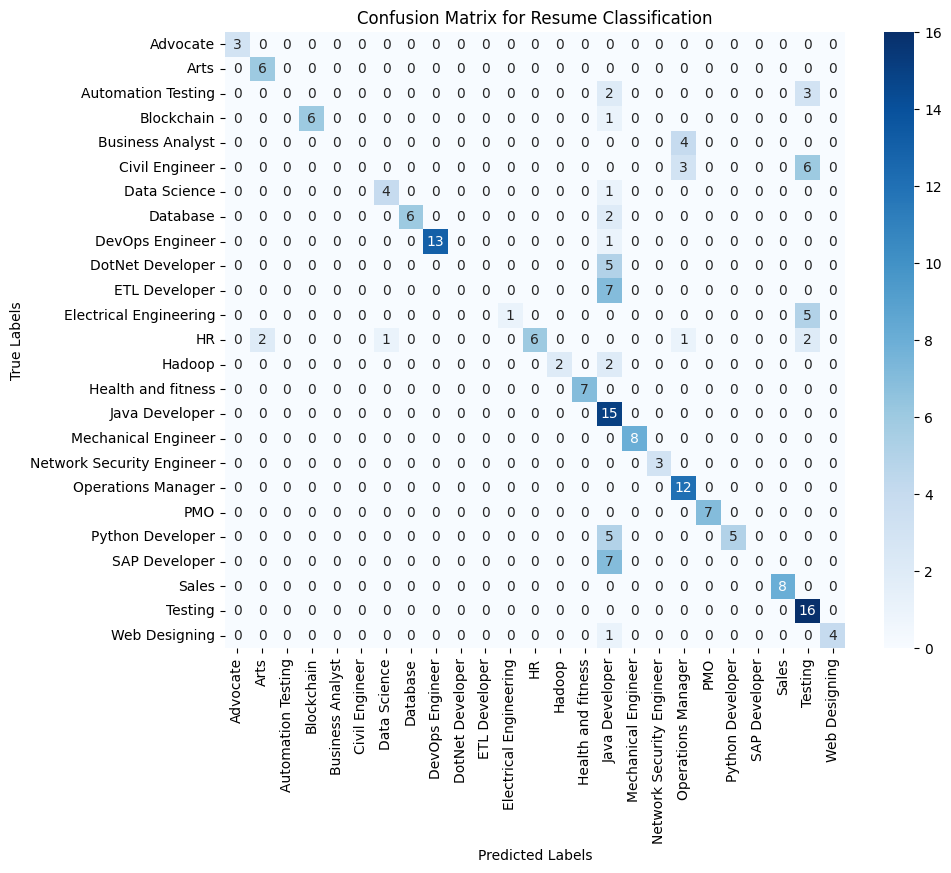


📄 Classification Report:
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       0.75      1.00      0.86         6
       Automation Testing       0.00      0.00      0.00         5
               Blockchain       1.00      0.86      0.92         7
         Business Analyst       0.00      0.00      0.00         4
           Civil Engineer       0.00      0.00      0.00         9
             Data Science       0.80      0.80      0.80         5
                 Database       1.00      0.75      0.86         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       0.00      0.00      0.00         5
            ETL Developer       0.00      0.00      0.00         7
   Electrical Engineering       1.00      0.17      0.29         6
                       HR       1.00      0.50      0.67        12
                   Hadoop       1.0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


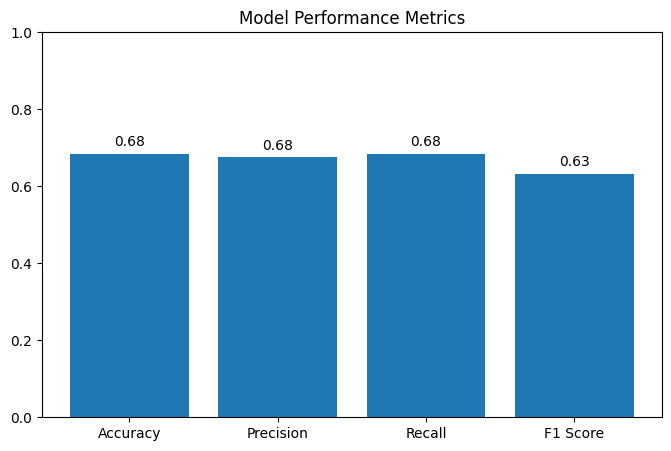

📊 Visualization completed successfully!


In [11]:
# STEP 7: CONFUSION MATRIX + CLASSIFICATION REPORT + PLOTS
# ---------------------------------------------------------

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---- Predict on Test Set ----
print("🔍 Generating predictions for confusion matrix...")
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Resume Classification")
plt.show()

# ---- Classification Report ----
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# ---- Accuracy Plot ----
acc = results['eval_accuracy']
f1 = results['eval_f1']
prec = results['eval_precision']
rec = results['eval_recall']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [acc, prec, rec, f1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, values)
plt.title("Model Performance Metrics")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

print("📊 Visualization completed successfully!")
